# Models

## Table of Contents
- Load Data
- Sample and Feature Preparation
    - Missing Data
    - One-Hot Encoding
    - Output Encoding
- Train-Test Split
- Utils
- Model Selection
    - LightGBM
        - Hyperparameter Tuning
        - Correlation Between Models
        - Pairwise Comparison of Models
        - Final Model Evaluation
- Final Model
    - Final Model
    - Metrics
    - Model Analysis
    - Feature Importance

In [1]:
import joblib
from copy import deepcopy
from itertools import combinations
import random
from math import factorial
from scipy import stats
from scipy.stats import t
import numpy as np
import pandas as pd

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# utils
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
    PrecisionRecallDisplay
) 
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# sns config
sns.set_style("whitegrid")
sns.set_palette("Blues_r")

In [3]:
# plotly config
import plotly.io as pio
pio.renderers.default = "browser"

template = "plotly_white"
colors = {
    "red": "rgb(255,0,0)",
    "dark_blue": "rgb(30,144,255)",
    "medium_blue": "rgb(0,191,255)",
    "light_blue": "rgb(135,206,250)",
    "dark_purple": "rgb(202, 105, 157)",
    "medium_purple": "rgb(221, 136, 172)",
    "light_purple": "rgb(234, 169, 189)",
    "dark_gray": "rgb(169,169,169)",
    "medium_gray": "rgb(192,192,192)",
    "light_gray": "rgb(211,211,211)"
}
title_font_size = 22
font_size = 18

# Load Data

- TODO: explain
- information not available at prediction time (new user being evaluated)

In [4]:
df_loans = pd.read_pickle("../data/processed/df_loans.pkl")
df_loans = df_loans[["id", "user_id", "amount_bin", "interest_rate_bin"]]

df_loans

,id,user_id,amount_bin,interest_rate_bin
0,0,3070,6k - 7k,small
1,1,2546,6k - 7k,small
2,2,2413,6k - 7k,small
3,3,2585,6k - 7k,small
4,4,2556,6k - 7k,small
...,...,...,...,...
6741,6741,2130,2k - 3k,large
6742,6742,549,6k - 7k,large
6743,6743,1414,6k - 7k,large
6744,6744,2070,6k - 7k,large


In [5]:
df_loan_repayments = pd.read_pickle("../data/processed/df_loan_repayments.pkl")

df_loan_repayments = df_loan_repayments[["id", "loan_id", "created_at", "amount", "status_cleaned", "days_since_loan_created", 
                                         "days_since_due_date", "due_date_exceeded", "days_lag_repayment", "num_late_repayments", 
                                         'prev_status', "prev_amount", "cumsum_amount", "ratio_repaid_total"]]
df_loan_repayments = df_loan_repayments.rename(columns={"id": "repayment_id", "amount": "repayment_amount"})

df_loan_repayments

,repayment_id,loan_id,created_at,repayment_amount,status_cleaned,days_since_loan_created,days_since_due_date,due_date_exceeded,days_lag_repayment,num_late_repayments,prev_status,prev_amount,cumsum_amount,ratio_repaid_total
50,51,0,2022-02-03,9.75,paid,2,0,0,2.0,0,init,0.00,9.75,0.001613
112,113,0,2022-02-04,45.30,paid,3,0,0,1.0,0,paid,9.75,55.05,0.009106
216,217,0,2022-02-05,25.50,paid,4,0,0,1.0,0,paid,45.30,80.55,0.013324
496,497,0,2022-02-08,10.50,paid,7,0,0,3.0,0,paid,25.50,91.05,0.015061
645,646,0,2022-02-09,226.50,paid,8,0,0,1.0,0,paid,10.50,317.55,0.052529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171446,171447,6745,2022-12-14,6.00,paid,72,0,0,1.0,0,paid,36.00,6387.14,1.056550
171543,171544,6745,2022-12-15,93.00,paid,73,0,0,1.0,0,paid,6.00,6480.14,1.071934
171881,171882,6745,2022-12-20,126.74,paid,78,0,0,5.0,0,paid,93.00,6606.88,1.092899
171963,171964,6745,2022-12-21,203.37,paid,79,0,0,1.0,0,paid,126.74,6810.25,1.126540


In [6]:
df_users = pd.read_pickle("../data/processed/df_users.pkl")

df_users = df_users[["user_id", "median_spending", "avg_intallments", "rate_denied", 
                     "rate_transactions_installment", "rate_credit_debit", "ratio_online_person"]]
df_users["rate_transactions_installment"] = df_users["rate_transactions_installment"].astype(float)

df_users

,user_id,median_spending,avg_intallments,rate_denied,rate_transactions_installment,rate_credit_debit,ratio_online_person
0,1,270.0,4.500000,0.300000,0.700000,4.500000,0.000000
1,2,1130.0,8.257143,0.057143,0.971429,17.000000,0.000000
2,3,1000.0,5.551282,0.115385,1.000000,78.000000,0.012821
3,4,307.5,2.646853,0.090909,0.419580,1.657407,0.003497
4,5,172.0,1.952081,0.083228,0.480454,131.333333,0.000000
...,...,...,...,...,...,...,...
3043,3149,240.0,1.935065,0.069264,0.333333,2.052632,0.004329
3044,3150,105.0,1.618375,0.174323,0.398115,2.586498,0.289833
3045,3151,207.0,2.687225,0.092511,0.568282,2.257143,0.017857
3046,3152,240.1,3.213775,0.135063,0.952594,61.166667,0.028493


In [7]:
df_users_segments = pd.read_pickle("../data/processed/df_users_segments.pkl")

df_users_segments

,user_id,rfm_segment_desc
0,1,Inactive
1,2,Inactive
2,3,Inactive
3,4,Promising
4,5,Promising
...,...,...
3043,3149,Inactive
3044,3150,Champions
3045,3151,Inactive
3046,3152,Promising


# Sample and Feature Preparation

- Missing Data
- One-Hot Encoding
- Output Encoding

In [8]:
# merge tables
df_users = df_users.merge(df_users_segments, how="left", on="user_id")
df_loans_users = df_loans.merge(df_users, how="left", on="user_id").rename(columns={"id": "loan_id"})
df_data = df_loan_repayments.merge(df_loans_users, how="left", on="loan_id")

In [9]:
# sort by loan_id and repayment date (ascending)
df_data = df_data.sort_values(by=["loan_id", "created_at"])

In [10]:
df_data = df_data.drop(columns=["created_at", "user_id"]) 

## Missing Data

TODO: new users

In [11]:
df_data.loc[df_data["rfm_segment_desc"].isna(), "rfm_segment_desc"] = "Recent"

# input missing values for user-related features by taking values 
# (median here) that are related to Recent customers' behavior
df_data.loc[df_data["ratio_online_person"].isna(), "ratio_online_person"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["ratio_online_person"].median()
df_data.loc[df_data["rate_credit_debit"].isna(), "rate_credit_debit"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["rate_credit_debit"].median()
df_data.loc[df_data["rate_transactions_installment"].isna(), "rate_transactions_installment"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["rate_transactions_installment"].median()
df_data.loc[df_data["rate_denied"].isna(), "rate_denied"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["rate_denied"].median()
df_data.loc[df_data["avg_intallments"].isna(), "avg_intallments"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["avg_intallments"].median()
df_data.loc[df_data["median_spending"].isna(), "median_spending"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["median_spending"].median()

## One-Hot Encoding

In [12]:
df_data = pd.concat([df_data, pd.get_dummies(df_data["prev_status"], prefix='prev_status')], axis=1)
df_data = df_data.drop(['prev_status'], axis=1)

In [13]:
df_data = pd.concat([df_data, pd.get_dummies(df_data["amount_bin"], prefix='amount_bin')], axis=1)
df_data = df_data.drop(['amount_bin'], axis=1)

In [14]:
df_data.status_cleaned.unique()

array(['paid', 'defaulted'], dtype=object)

In [15]:
df_data = pd.concat([df_data, pd.get_dummies(df_data["interest_rate_bin"], prefix='interest_rate_bin')], axis=1)
df_data = df_data.drop(['interest_rate_bin'], axis=1)

In [16]:
df_data = pd.concat([df_data, pd.get_dummies(df_data["rfm_segment_desc"], prefix='rfm_segment')], axis=1)
df_data = df_data.drop(['rfm_segment_desc'], axis=1)

## Output Encoding

In [17]:
mapping = {
    "defaulted": 1,
    "paid": 0,
}
df_data["status_cleaned"] = df_data["status_cleaned"].replace(mapping)

# Train-Test Split

TODO: explain + print

In [18]:
def custom_train_test_split(data, primary_key, output_key, split_key, test_size, random_state):
    """

    Args:
    
    Returns:
    
    """
    train_ids, test_ids = train_test_split(list(set(data[split_key])), test_size=test_size, random_state=random_state)

    train, test = df_data[df_data[split_key].isin(train_ids)], df_data[df_data[split_key].isin(test_ids)]

    X_train, y_train = train.loc[:, ~train.columns.isin([primary_key, output_key])], train.loc[:, train.columns == output_key]
    X_test, y_test = test.loc[:, ~test.columns.isin([primary_key, output_key])], test.loc[:, test.columns == output_key]

    return X_train, y_train, X_test, y_test

In [19]:
X_train, y_train, X_test, y_test = custom_train_test_split(
    df_data, 
    primary_key="repayment_id", 
    output_key="status_cleaned", 
    split_key="loan_id", 
    test_size=0.2, 
    random_state=42
)

In [20]:
print(f"Train: number of loans: {X_train['loan_id'].unique().shape[0]:,}\nTest: number of loans: {X_test['loan_id'].unique().shape[0]:,}")

Train: number of loans: 5,278
Test: number of loans: 1,320


In [21]:
print(f"Train: number of loan repayments: {X_train.shape[0]:,}\nTest: number of loan repayments: {X_test.shape[0]:,}")

Train: number of loan repayments: 138,204
Test: number of loan repayments: 34,241


In [22]:
paid, defaulted = y_train[y_train["status_cleaned"] == 0].shape[0], y_train[y_train["status_cleaned"] == 1].shape[0]
print(f"Train:\n\tnumber of paid repayments: {paid:,}\n\tnumber of defaulted repayments: {defaulted:,}")

paid, defaulted = y_test[y_test["status_cleaned"] == 0].shape[0], y_test[y_test["status_cleaned"] == 1].shape[0]
print(f"Test:\n\tnumber of paid repayments: {paid:,}\n\tnumber of defaulted repayments: {defaulted:,}")

Train:
	number of paid repayments: 131,220
	number of defaulted repayments: 6,984
Test:
	number of paid repayments: 32,485
	number of defaulted repayments: 1,756


In [23]:
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

# Utils

TODO: talk about cv and why (add comments)

In [24]:
def corrected_std(differences, n_train, n_test):
    """ Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters:
        differences:
            Vector containing the differences in the score metrics of two models.
        n_train:
            Number of samples in the training set.
        n_test:
            Number of samples in the testing set.

    Returns:
        corrected_std:
            Variance-corrected standard deviation of the set of differences.
    """
    kr = len(differences)  # number of times the model was evaluated
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

In [25]:
def compute_corrected_ttest(differences, df, n_train, n_test):
    """ Computes right-tailed paired t-test with corrected variance.

    Parameters:
        differences:
            Vector containing the differences in the score metrics of two models.
        df:
            Degrees of freedom.
        n_train:
            Number of samples in the training set.
        n_test:
            Number of samples in the testing set.

    Returns:
        t_stat:
            Variance-corrected t-statistic.
        p_val:
            Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [26]:
def k_fold(X, primary_key, folds):
    """
    
    Args:
    
    Returns:
    
    """
    ids = list(set(X[primary_key]))
    random.shuffle(ids)

    fold_ids = np.array_split(ids, folds)

    cv = []
    for fold in range(folds):
        train_ids = fold_ids[fold].tolist()
        test_ids = []
        for i in range(folds):
            if i != fold:
                test_ids.extend(fold_ids[i].tolist())
                
        train_indexes = X_train[X_train["loan_id"].isin(train_ids)].index.values
        test_indexes = X_train[X_train["loan_id"].isin(test_ids)].index.values
        cv.append((train_indexes, test_indexes))
        
    return cv

In [27]:
folds = 10

cv = k_fold(X_train, primary_key="loan_id", folds=10)

In [28]:
X_train_aux, X_test_aux = X_train.drop(columns=["loan_id"]), X_test.drop(columns=["loan_id"])

# Model Selection

In [29]:
labels = ["paid", "defaulted"]

## Random Forest

todo: conclusion + results

### Hyperparameter Tuning

In [30]:
pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# hyperparameter space
parameters = {
    'clf__n_estimators': list(range(50, 550, 50)),
    'clf__max_depth': list(range(5, 55, 5)) + [None],
    'clf__class_weight': ["balanced", "balanced_subsample"]
}

In [ ]:
# hyperparameter tuning
search = RandomizedSearchCV(pipe,
                            parameters,
                            n_iter=60,
                            scoring=["f1_weighted", "precision_weighted", "recall_weighted"],
                            refit="f1_weighted",
                            cv=cv,
                            return_train_score=True,
                            random_state=42,
                            verbose=10)

search.fit(X_train, np.ravel(y_train))


In [32]:
print(f'Best search train weighted F1-score: {search.cv_results_["mean_train_f1_weighted"][search.best_index_]:,.2f}')
print(f'Best search eval weighted F1-score: {search.cv_results_["mean_test_f1_weighted"][search.best_index_]:,.2f}\n')

print(f'Best search train weighted Precision: {search.cv_results_["mean_train_precision_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Precision: {search.cv_results_["mean_test_precision_weighted"][search.best_index_]:.2f}\n')

print(f'Best search train weighted Recall: {search.cv_results_["mean_train_recall_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Recall: {search.cv_results_["mean_test_recall_weighted"][search.best_index_]:.2f}\n')

print(f'Best search parameters:\n{search.best_params_}')

Best search train weighted F1-score: 0.97
Best search eval weighted F1-score: 0.95

Best search train weighted Precision: 0.97
Best search eval weighted Precision: 0.95

Best search train weighted Recall: 0.97
Best search eval weighted Recall: 0.95

Best search parameters:
{'clf__n_estimators': 500, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'}


### Correlation Between Models

We can observe tha **tthe performance of the models highly depends on the fold**.

As a consequence, if we assume independence between samples we will be underestimating the variance computed in our statistical tests, increasing the number of false positive errors (i.e. detecting a significant difference between models when such does not exist)

In [33]:
df_results = pd.DataFrame(search.cv_results_).sort_values(by=["rank_test_f1_weighted"])
df_results = df_results.set_index(
    df_results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("iter")
df_results[["params", "rank_test_f1_weighted", "mean_train_f1_weighted", "mean_test_f1_weighted", 
            "rank_test_precision_weighted", "mean_train_precision_weighted", "mean_test_precision_weighted", 
            "rank_test_recall_weighted", "mean_train_recall_weighted", "mean_test_recall_weighted"]].head(3)

,params,rank_test_f1_weighted,mean_train_f1_weighted,mean_test_f1_weighted,rank_test_precision_weighted,mean_train_precision_weighted,mean_test_precision_weighted,rank_test_recall_weighted,mean_train_recall_weighted,mean_test_recall_weighted
iter,,,,,,,,,,
500_10_balanced,"{'clf__n_estimators': 500, 'clf__max_depth': 1...",1,0.967682,0.949209,45,0.967621,0.947465,51,0.967857,0.951592
450_10_balanced,"{'clf__n_estimators': 450, 'clf__max_depth': 1...",2,0.967626,0.949195,44,0.967583,0.947467,52,0.967783,0.951549
400_10_balanced_subsample,"{'clf__n_estimators': 400, 'clf__max_depth': 1...",3,0.967602,0.949186,47,0.967544,0.947447,53,0.967771,0.951545


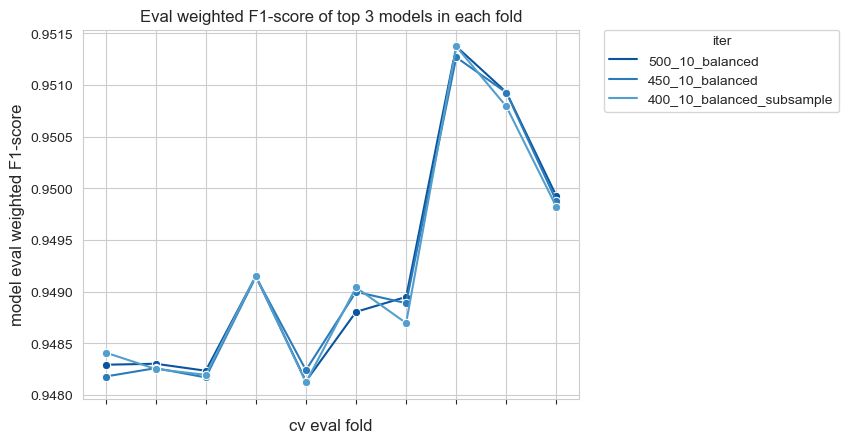

In [34]:
# model scores ordered by performance
model_f1 = df_results.filter(regex=r"split\d*_test_f1_weighted").iloc[:3]

fig, ax = plt.subplots()

sns.lineplot(
    data=model_f1.transpose(),
    dashes=False,
    marker="o",
    ax=ax,
)

ax.set_title('Eval weighted F1-score of top 3 models in each fold')
ax.set_xlabel("cv eval fold", size=12, labelpad=10)
ax.set_ylabel("model eval weighted F1-score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.legend(title='iter', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [35]:
# correlation of weighted F1-score across folds
print(f"Correlation of models based on weighted F1-score:\n")
model_f1.transpose().corr()

Correlation of models based on weighted F1-score:



iter,500_10_balanced,450_10_balanced,400_10_balanced_subsample
iter,,,
500_10_balanced,1.000000,0.996659,0.993431
450_10_balanced,0.996659,1.000000,0.994075
400_10_balanced_subsample,0.993431,0.994075,1.000000


### Pairwise Comparison of Models

[Frequentist Approach](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#): Run a paired t-test and compute the p-value.

We observe that the models **don't significantly differ** from each other, thus we can select the proposed model from hyperaparameter tuning.

In [36]:
# pairwise comparison of models based on weighted F1-score

n_train = len(cv[0][0])
n_test = len(cv[0][1])

n_comparisons = factorial(len(model_f1)) / (factorial(2) * factorial(len(model_f1) - 2))
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_f1)), 2):
    model_i_scores = model_f1.iloc[model_i].values
    model_k_scores = model_f1.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    n = differences.shape[0]  # number of test sets
    df = n - 1
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # Bonferroni correction
    p_val = 1 if p_val > 1 else p_val  # Bonferroni can output p-values higher than 1
    pairwise_t_test.append([model_f1.index[model_i], model_f1.index[model_k], t_stat, p_val])

pairwise_comp_df = pd.DataFrame(pairwise_t_test, 
                                columns=["model_1", "model_2", "t_stat", "p_val"]).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,500_10_balanced,450_10_balanced,0.050,1
1,500_10_balanced,400_10_balanced_subsample,0.059,1
2,450_10_balanced,400_10_balanced_subsample,0.026,1


### Final Model Evaluation

---

**Best model parameters:** 

---

**Best model train weighted F1-score:** x%
- class paid: x
- class defaulted: x%

**Best model eval weighted F1-score:** x%
- class paid: x%
- class defaulted: x%

---

**Best model train weighted Precision:** x%
- class paid: x%
- class defaulted: x%

**Best model eval weighted Precision:** x%
- class paid: x%
- class defaulted: x%

---

**Best model train weighted Recall:** x%

**Best model eval weighted Recall:** x%

---

**Conclusion:** TODO

In [37]:
X_temp, y_temp, X_eval, y_eval = custom_train_test_split(
    pd.concat([X_train, y_train], axis=1), 
    primary_key="repayment_id", 
    output_key="status_cleaned", 
    split_key="loan_id", 
    test_size=0.2, 
    random_state=42
)

X_temp, X_eval = X_temp.drop(columns=["loan_id"]), X_eval.drop(columns=["loan_id"])

In [ ]:
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight= 'balanced',
    random_state=42
)

clf.fit(X_temp, np.ravel(y_temp))

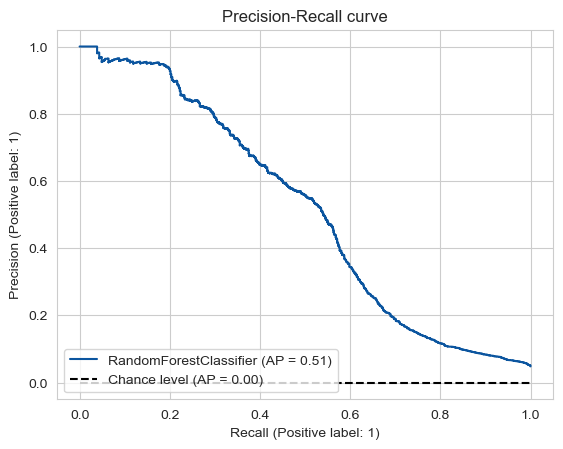

In [39]:
display = PrecisionRecallDisplay.from_estimator(
    clf, 
    X_eval, 
    y_eval, 
    plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")

In [40]:
y_train_pred = clf.predict(X_temp)
y_eval_pred = clf.predict(X_eval)

In [41]:
print(f"Train:\n{classification_report(y_temp, y_train_pred, target_names=labels)}")
print(f"Eval:\n{classification_report(y_eval, y_eval_pred, target_names=labels)}")

Train:
              precision    recall  f1-score   support

        paid       0.98      0.95      0.97    106152
   defaulted       0.41      0.62      0.50      5720

    accuracy                           0.94    111872
   macro avg       0.70      0.79      0.73    111872
weighted avg       0.95      0.94      0.94    111872

Eval:
              precision    recall  f1-score   support

        paid       0.98      0.95      0.97     25068
   defaulted       0.39      0.58      0.46      1264

    accuracy                           0.94     26332
   macro avg       0.68      0.77      0.72     26332
weighted avg       0.95      0.94      0.94     26332



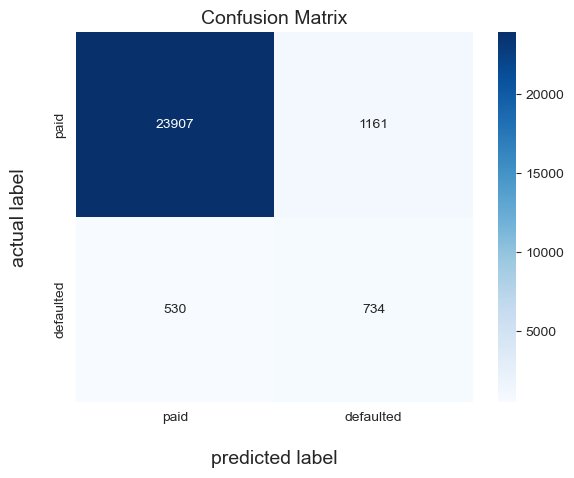

In [42]:
cm = confusion_matrix(y_eval, y_eval_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

## LightGBM

todo: conclusion

### Hyperparameter Tuning

In [30]:
pipe = Pipeline([
    ('clf', LGBMClassifier(random_state=42))
])

# hyperparameter space
parameters = {
    'clf__n_estimators': list(range(50, 550, 50)),
    'clf__max_depth': list(range(5, 55, 5)),
    'clf__colsample_bytree': [.4, .5, .6, .8, 1],
    'clf__learning_rate': [1, 1e-1, 1e-2, 1e-3],
    'clf__boosting_type': ['gbdt', 'dart']
}

In [ ]:
# hyperparameter tuning
search = RandomizedSearchCV(pipe,
                            parameters,
                            n_iter=60,
                            scoring=["f1_weighted", "precision_weighted", "recall_weighted"],
                            refit="f1_weighted",
                            cv=cv,
                            return_train_score=True,
                            random_state=42,
                            verbose=10)

search.fit(X_train_aux, np.ravel(y_train))

In [32]:
print(f'Best search train weighted F1-score: {search.cv_results_["mean_train_f1_weighted"][search.best_index_]:,.2f}')
print(f'Best search eval weighted F1-score: {search.cv_results_["mean_test_f1_weighted"][search.best_index_]:,.2f}\n')

print(f'Best search train weighted Precision: {search.cv_results_["mean_train_precision_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Precision: {search.cv_results_["mean_test_precision_weighted"][search.best_index_]:.2f}\n')

print(f'Best search train weighted Recall: {search.cv_results_["mean_train_recall_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Recall: {search.cv_results_["mean_test_recall_weighted"][search.best_index_]:.2f}\n')

print(f'Best search parameters:\n{search.best_params_}')

Best search train weighted F1-score: 0.97
Best search eval weighted F1-score: 0.95

Best search train weighted Precision: 0.97
Best search eval weighted Precision: 0.96

Best search train weighted Recall: 0.97
Best search eval weighted Recall: 0.96

Best search parameters:
{'clf__n_estimators': 450, 'clf__max_depth': 50, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8, 'clf__boosting_type': 'gbdt'}


### Correlation Between Models

We can observe tha **tthe performance of the models highly depends on the fold**.

As a consequence, if we assume independence between samples we will be underestimating the variance computed in our statistical tests, increasing the number of false positive errors (i.e. detecting a significant difference between models when such does not exist)

In [33]:
df_results = pd.DataFrame(search.cv_results_).sort_values(by=["rank_test_f1_weighted"])
df_results = df_results.set_index(
    df_results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("iter")
df_results[["params", "rank_test_f1_weighted", "mean_train_f1_weighted", "mean_test_f1_weighted", 
            "rank_test_precision_weighted", "mean_train_precision_weighted", "mean_test_precision_weighted", 
            "rank_test_recall_weighted", "mean_train_recall_weighted", "mean_test_recall_weighted"]].head(3)

,params,rank_test_f1_weighted,mean_train_f1_weighted,mean_test_f1_weighted,rank_test_precision_weighted,mean_train_precision_weighted,mean_test_precision_weighted,rank_test_recall_weighted,mean_train_recall_weighted,mean_test_recall_weighted
iter,,,,,,,,,,
450_50_0.01_0.8_gbdt,"{'clf__n_estimators': 450, 'clf__max_depth': 5...",1,0.968350,0.953170,2,0.972810,0.957935,1,0.972831,0.961837
400_10_0.01_0.8_gbdt,"{'clf__n_estimators': 400, 'clf__max_depth': 1...",2,0.967116,0.953020,3,0.971750,0.957686,2,0.971911,0.961695
200_5_0.1_1_gbdt,"{'clf__n_estimators': 200, 'clf__max_depth': 5...",3,0.978374,0.952798,23,0.980711,0.955615,7,0.980524,0.960962


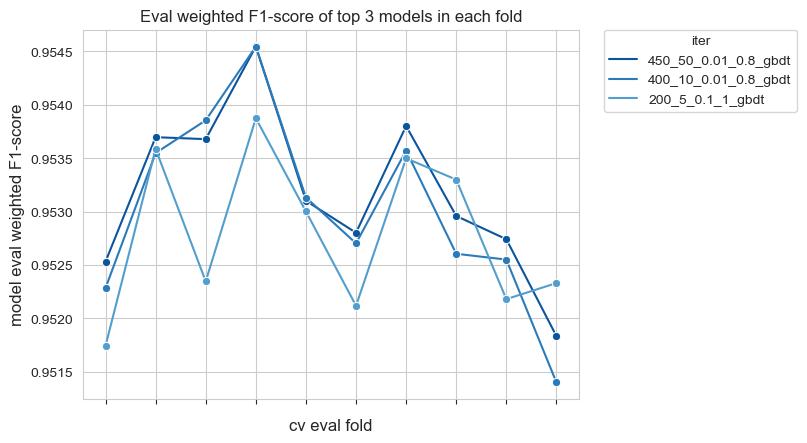

In [34]:
# model scores ordered by performance
model_f1 = df_results.filter(regex=r"split\d*_test_f1_weighted").iloc[:3]

fig, ax = plt.subplots()

sns.lineplot(
    data=model_f1.transpose(),
    dashes=False,
    marker="o",
    ax=ax,
)

ax.set_title('Eval weighted F1-score of top 3 models in each fold')
ax.set_xlabel("cv eval fold", size=12, labelpad=10)
ax.set_ylabel("model eval weighted F1-score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.legend(title='iter', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [35]:
# correlation of weighted F1-score across folds
print(f"Correlation of models based on weighted F1-score:\n")
model_f1.transpose().corr()

Correlation of models based on weighted F1-score:



iter,450_50_0.01_0.8_gbdt,400_10_0.01_0.8_gbdt,200_5_0.1_1_gbdt
iter,,,
450_50_0.01_0.8_gbdt,1.000000,0.987041,0.736836
400_10_0.01_0.8_gbdt,0.987041,1.000000,0.653910
200_5_0.1_1_gbdt,0.736836,0.653910,1.000000


### Pairwise Comparison of Models

[Frequentist Approach](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#): Run a paired t-test and compute the p-value.

We observe that the models **don't significantly differ** from each other, thus we can select the proposed model from hyperaparameter tuning.

In [36]:
# pairwise comparison of models based on weighted F1-score

n_train = len(cv[0][0])
n_test = len(cv[0][1])

n_comparisons = factorial(len(model_f1)) / (factorial(2) * factorial(len(model_f1) - 2))
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_f1)), 2):
    model_i_scores = model_f1.iloc[model_i].values
    model_k_scores = model_f1.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    n = differences.shape[0]  # number of test sets
    df = n - 1
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # Bonferroni correction
    p_val = 1 if p_val > 1 else p_val  # Bonferroni can output p-values higher than 1
    pairwise_t_test.append([model_f1.index[model_i], model_f1.index[model_k], t_stat, p_val])

pairwise_comp_df = pd.DataFrame(pairwise_t_test, 
                                columns=["model_1", "model_2", "t_stat", "p_val"]).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,450_50_0.01_0.8_gbdt,400_10_0.01_0.8_gbdt,0.273,1
1,450_50_0.01_0.8_gbdt,200_5_0.1_1_gbdt,0.225,1
2,400_10_0.01_0.8_gbdt,200_5_0.1_1_gbdt,0.106,1


### Final Model Evaluation

---

**Best model parameters:** n_estimators: 450, max_depth: 50, learning_rate: 0.01, colsample_bytree: 0.8, booster: 'gbdt'

---

**Best model train weighted F1-score:** 93%
- class paid: 98%
- class defaulted: 52%

**Best model eval weighted F1-score:** 96%
- class paid: 98%
- class defaulted: 51%

---

**Best model train weighted Precision:** 93%
- class paid: 97%
- class defaulted: 91%

**Best model eval weighted Precision:** 96%
- class paid: 97%
- class defaulted: 88%

---

**Best model train weighted Recall:** 97%

**Best model eval weighted Recall:** 97%

---

**Conclusion:** TODO

In [37]:
X_temp, y_temp, X_eval, y_eval = custom_train_test_split(
    pd.concat([X_train, y_train], axis=1), 
    primary_key="repayment_id", 
    output_key="status_cleaned", 
    split_key="loan_id", 
    test_size=0.2, 
    random_state=42
)

X_temp, X_eval = X_temp.drop(columns=["loan_id"]), X_eval.drop(columns=["loan_id"])

In [ ]:
clf = LGBMClassifier(
    n_estimators=450,
    max_depth=50,
    learning_rate=0.01,
    colsample_bytree=0.8,
    boosting_type='gbdt',
    random_state=42
)

clf.fit(X_temp, np.ravel(y_temp))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


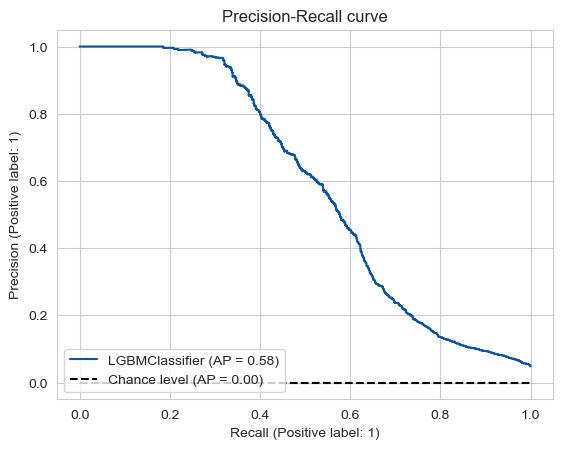

In [40]:
display = PrecisionRecallDisplay.from_estimator(
    clf, 
    X_eval, 
    y_eval, 
    plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")

In [ ]:
y_train_pred = clf.predict(X_temp)
y_eval_pred = clf.predict(X_eval)

In [45]:
print(f"Train:\n{classification_report(y_temp, y_train_pred, target_names=labels)}")
print(f"Eval:\n{classification_report(y_eval, y_eval_pred, target_names=labels)}")

Train:
              precision    recall  f1-score   support

        paid       0.97      1.00      0.98    106152
   defaulted       0.91      0.36      0.52      5720

    accuracy                           0.97    111872
   macro avg       0.94      0.68      0.75    111872
weighted avg       0.96      0.97      0.96    111872

Eval:
              precision    recall  f1-score   support

        paid       0.97      1.00      0.98     25068
   defaulted       0.88      0.36      0.51      1264

    accuracy                           0.97     26332
   macro avg       0.92      0.68      0.75     26332
weighted avg       0.96      0.97      0.96     26332



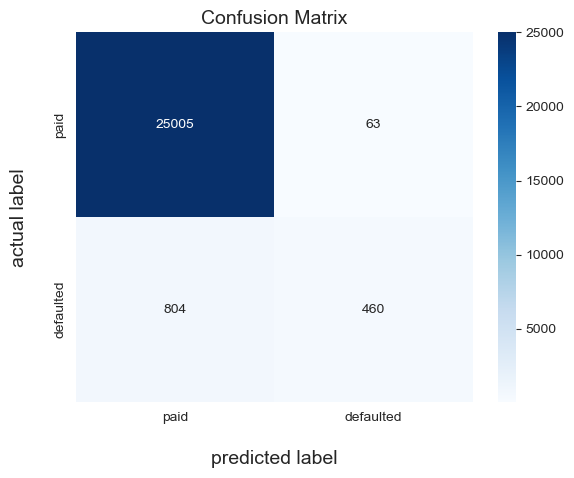

In [44]:
cm = confusion_matrix(y_eval, y_eval_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

# Final Model

---

**Model:** x

**Parameters:** x

*The final model has been chosen based on the best weighted F1-score, Precision and Recall on the evaluation sample. Also, the degree of overfittng (or underfitting) has been taken into consideration.*

---

**Train weighted F1-score:** x%
- class x: x%
- class x: x%

**Test weighted F1-score:** x%
- class x: x%
- class x: x%

---

**Train weighted Precision**: x%

**Test weighted Precision:** x%

---

**Train weighted Recall**: x%

**Test weighted Recall:** x%

---

**Conclusion:**
- x

## Final Model

## Metrics

## Model Analysis

## Feature Importance

## ✅ checkpoint